# Descripción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

 # Tabla de contenidos

* [1- Importación de librerias y carga de datos](#chapter1)

    
* [2 - Analisis exploratorio de datos](#chapter2)
    
* [3- Preparacion de datos y procedimiento de evaluación](#chapter3)


* [4- Modelos](#chapter4)

    * [4 - 1 Regresión Logística](#section_4_1)
    * [4 - 2 Arbol de desición](#section_4_2) 
    * [4 - 3 Bosque aleatorio](#section_4_3) 
        
* [5- Prueba de modelos](#chapter5)   

* [6- Conclusiones](#chapter6)   

## Importación de librerias y carga de datos <a class="anchor" id="chapter1"></a>

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm
import sklearn.metrics as metrics
import re
from sklearn.dummy import DummyClassifier

import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords
import spacy
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

# Carga de datos

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA  <a class="anchor" id="chapter2"></a>

Veamos el número de películas y reseñas a lo largo de los años.

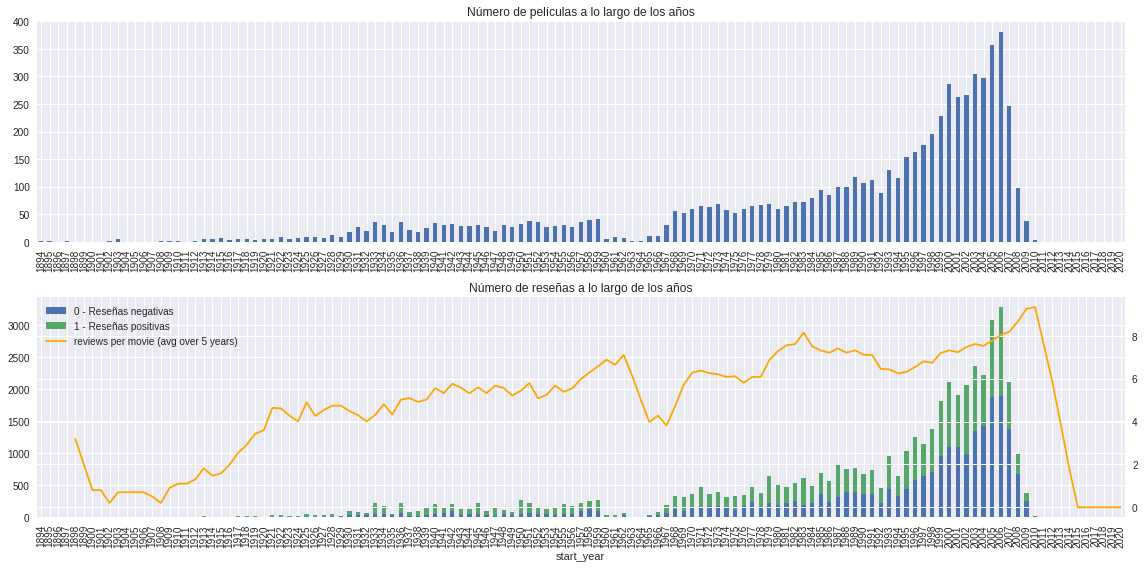

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

# agregando labels
lines, labels = ax.get_legend_handles_labels()
labels = ['0 - Reseñas negativas', '1 - Reseñas positivas']
lines_2, labels_2 = axt.get_legend_handles_labels()
ax.legend(lines + lines_2, labels + labels_2, loc='upper left')

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

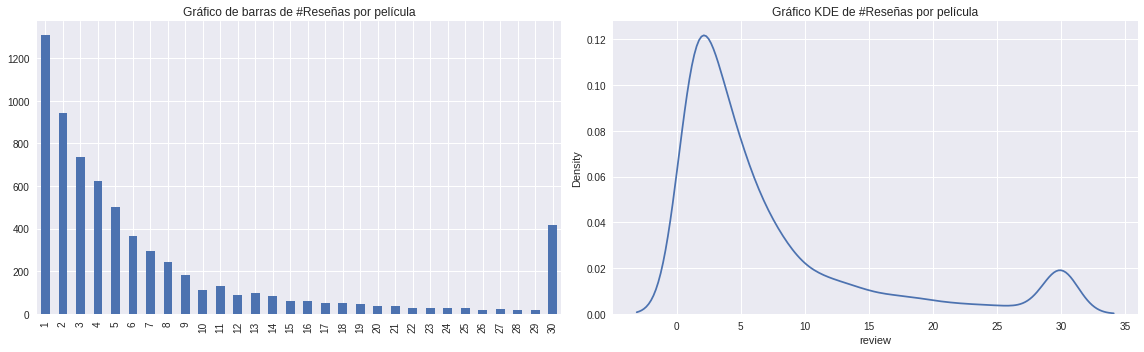

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

 - La gran mayotia de las peliculas cuenta con 1 reseña

In [9]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

 - Las clases se encuentran equilibradas

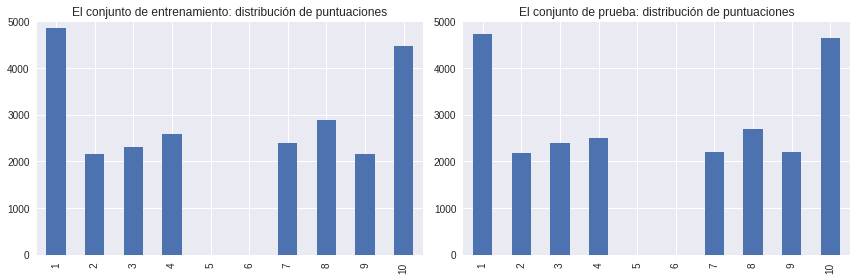

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

 - La distrubucion de reseñas es similar tanto en el conjunto de prueba como en el de entrenamiento

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


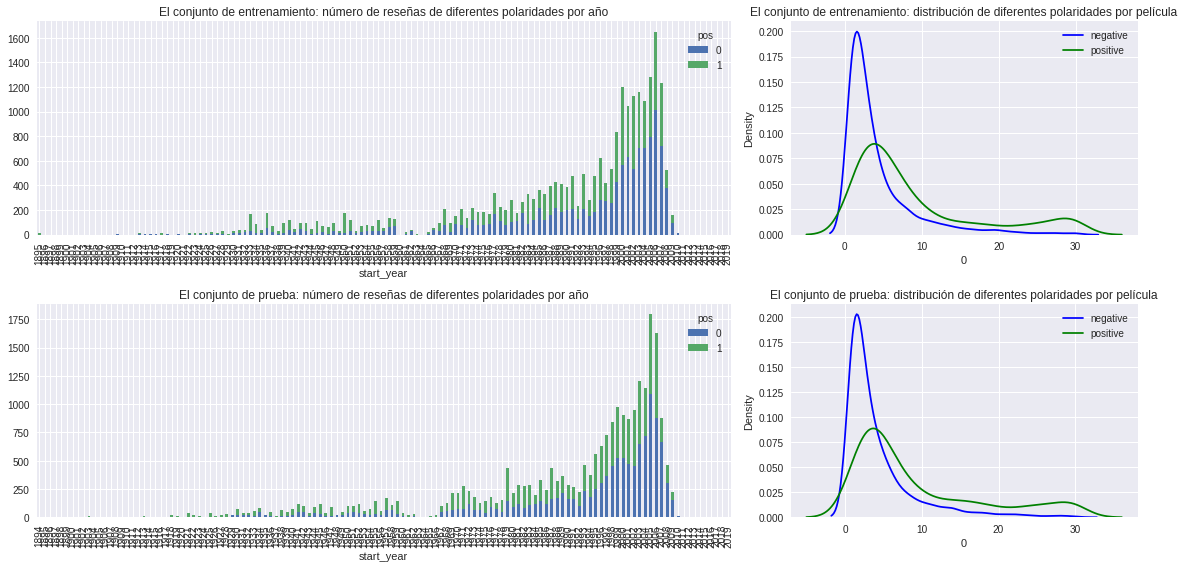

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

- La distrubucion de reseñas a lo largo del tiempo, es similar tanto en el conjunto de prueba como en el de entrenamiento

## Preparacion de datos y procedimiento de evaluación  <a class="anchor" id="chapter3"></a>

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [44]:

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Exactitud'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return




# Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [45]:

#cracion de una funcion para limpiar text0

def clear_text(text):
    pattern = r"[^a-zA-z /']" 
    text = re.sub(pattern,'', text)
    text = text.lower()
    return text




In [46]:
#aplicacion de la funcion al df
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

In [47]:
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47331, dtype: object

In [48]:
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um  a serious film about troubled teens in sin...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47331, dtype: object

# División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [12]:


df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 17)
(23535, 17)


## Modelos  <a class="anchor" id="chapter4"></a>

### Modelo 0 - Constante <a class="anchor" id="section_4_1"></a>

In [50]:


train_features_1 = df_reviews_train['review_norm']
test_features_1 = df_reviews_test['review_norm']


In [51]:
#Creacion de modelo dummy

model_dummy = DummyClassifier(strategy = 'constant', random_state = 12345, constant=1)
model_dummy.fit(train_features_1, train_target)




DummyClassifier(constant=1, random_state=12345, strategy='constant')

           train  test
Exactitud   0.50  0.50
F1          0.67  0.67
APS         0.50  0.50
ROC AUC     0.50  0.50


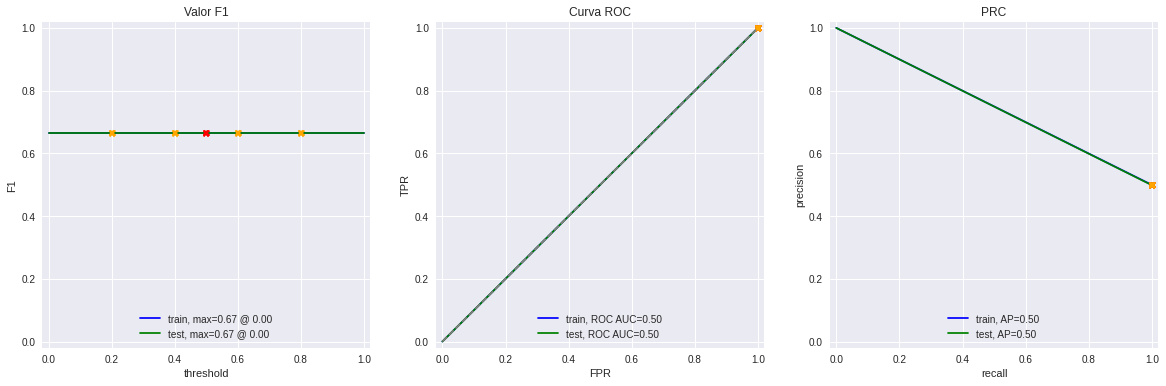

In [52]:
evaluate_model(model_dummy, train_features_1, train_target, test_features_1, test_target)
 

 - El modelo dummy es equivalente a un modelo aleatorio ("tirar una modela") con una probabilidad de clase positiva de 0,5 , observados en la curva ROC y PRC. 
 - Este modelo no sera indicado para realizar predicciones

In [53]:
#Calculo de accuracy por fuera de la funcion

pred_target = model_dummy.predict(test_features_1)
metrics.accuracy_score(test_target, pred_target)


0.4984916082430423

### Modelo 1 - NLTK, TF-IDF y LR <a class="anchor" id="section_4_2"></a>

TF-IDF

In [54]:
#Caracteristicas conjunto de entrenamiento
corpus = df_reviews_train['review_norm']

count_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'))

tf_idf = count_tf_idf.fit_transform(corpus)

tf_idf.shape

(23796, 99414)

In [55]:
train_features_2 = tf_idf

In [56]:
corpus_test = df_reviews_test['review_norm']

tf_idf_test = count_tf_idf.transform(corpus_test)

tf_idf.shape

(23796, 99414)

In [57]:
test_features_2 = tf_idf_test


In [58]:
#modelo

model_log = LogisticRegression()

In [59]:
model_log.fit(train_features_2, train_target)


LogisticRegression()

In [60]:
 model_log.predict(test_features_2)

array([0, 1, 1, ..., 1, 1, 1])

           train  test
Exactitud   0.94  0.88
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


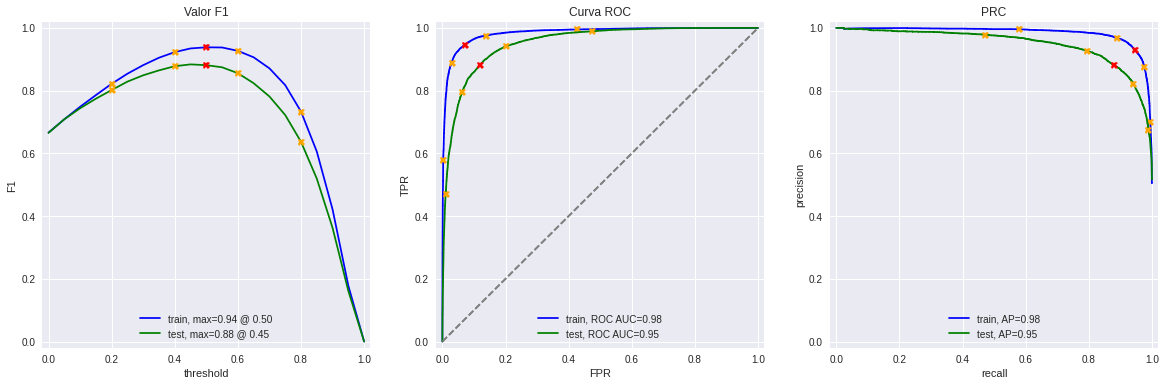

In [61]:
evaluate_model(model_log, train_features_2, train_target, test_features_2, test_target)

- Los valores de las metricas obtenidos con el modelo  NLTK, TF-IDF y LR, son muy altos (cercanos a 1) tanto en el conjunto de prueba como en el de entrenamiento. Es posible que se este en presencia de un modelo sobreajustado

In [62]:
# Accuracy
pred_target_log = model_log.predict(test_features_2)
metrics.accuracy_score(test_target, pred_target_log)

0.8815806246016571

### Modelo 3 - spaCy, TF-IDF y LR <a class="anchor" id="section_4_3"></a>

In [63]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [64]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [65]:
# #caracteristicas conjunto de entrenamiento
corpus_2 = df_reviews_train['review_norm'].apply(text_preprocessing_3)
# train_features_3

In [66]:
                             
                              
#corpus = df_reviews_train['review_norm']

count_tf_idf_2 = TfidfVectorizer(stop_words=stopwords.words('english'))

tf_idf_2 = count_tf_idf_2.fit_transform(corpus_2)

tf_idf_2                         
                              
                              

<23796x86732 sparse matrix of type '<class 'numpy.float64'>'
	with 1954337 stored elements in Compressed Sparse Row format>

In [67]:
corpus_test_2 = df_reviews_test['review_norm'].apply(text_preprocessing_3)



In [68]:
tf_idf_2_test = count_tf_idf_2.transform(corpus_test_2)

tf_idf_2_test

<23535x86732 sparse matrix of type '<class 'numpy.float64'>'
	with 1828235 stored elements in Compressed Sparse Row format>

In [69]:
model_lr_spa = LogisticRegression()

model_lr_spa.fit(tf_idf_2, train_target)


LogisticRegression()

           train  test
Exactitud   0.93  0.88
F1          0.93  0.87
APS         0.98  0.94
ROC AUC     0.98  0.95


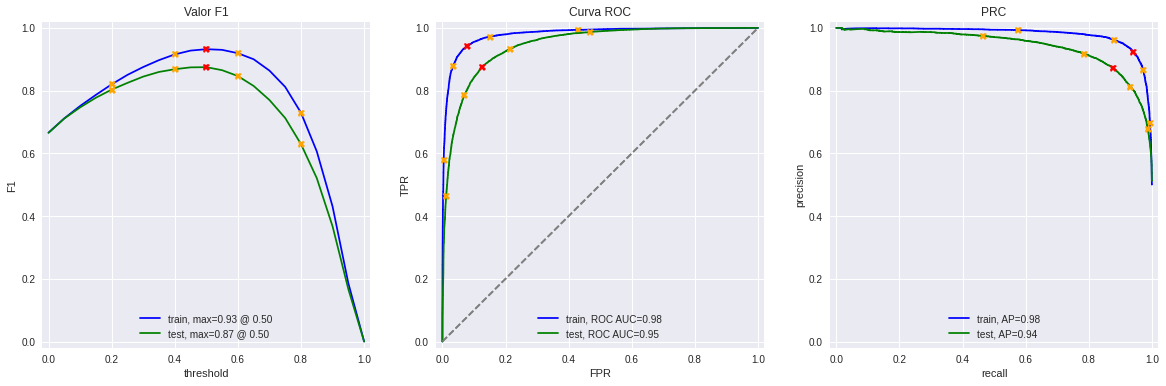

In [70]:
#Evaluacion del modelo
evaluate_model(model_lr_spa, tf_idf_2 , train_target, tf_idf_2_test, test_target)

- Al igual que sucede con los valores de las metricas obtenidos con el modelo  NLTK, TF-IDF y LR, los valores de metricas obtenidos ocn el modelo Spacy, TF-IDF y LR,  son muy altos (cercanos a 1) tanto en el conjunto de prueba como en el de entrenamiento. Es posible que se este en presencia de un modelo sobreajustado

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier<a class="anchor" id="section_4_4"></a>

In [71]:
#modelo lgvm
clf = lgb.LGBMClassifier()
clf.fit(tf_idf_2, train_target)

LGBMClassifier()

           train  test
Exactitud   0.91  0.85
F1          0.91  0.85
APS         0.97  0.93
ROC AUC     0.97  0.93


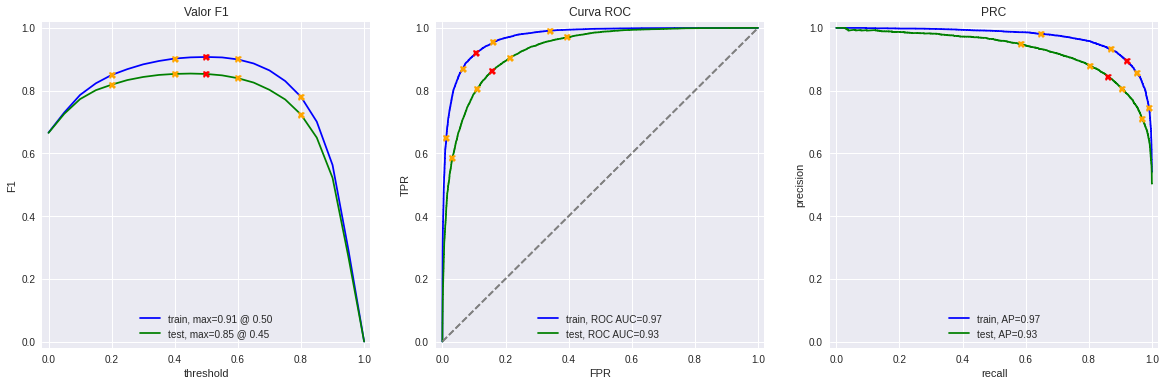

In [72]:
#Evaluacion del modelo
evaluate_model(clf, tf_idf_2 , train_target, tf_idf_2_test, test_target)

- Las metricas obtenidas con el modelo LGVM, al igual que con los modelos anteriores, denotan la posible presencia de modelo sobreajsutado

## Prueba de modelos - Mis reseñas <a class="anchor" id="chapter5"></a>

In [73]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

#my_reviews['review_norm'] = ...# <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>
my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...
2,I was really fascinated with the movie,i was really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i reall...


### Modelo 1

In [74]:
#predicciones con modelo 1

texts = my_reviews['review_norm']

my_reviews_pred_prob = model_log.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.17:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.46:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.83:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


In [75]:
train_features_2.shape

(23796, 99414)

In [76]:
count_tf_idf.transform(texts)


<8x99414 sparse matrix of type '<class 'numpy.float64'>'
	with 70 stored elements in Compressed Sparse Row format>

### Modelo 2

In [77]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_lr_spa.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')
    
    
    

0.16:  i did not simply like it not my kind of movie
0.07:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.14:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didn't expect the reboot to be so good writers really cared about the source material
0.38:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.02:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


### Modelo 3

In [78]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = clf.predict_proba(count_tf_idf_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  i did not simply like it not my kind of movie
0.22:  well i was bored and felt asleep in the middle of the movie
0.59:  i was really fascinated with the movie
0.43:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.69:  i didn't expect the reboot to be so good writers really cared about the source material
0.51:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.27:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.80:  launching on netflix was a brave move  i really appreciate being able to binge on episode after epis


 - Al evaluar las predicciones para "mis reseñas", se observa que en todos los modelos hay ciertos probabilidades no adecuadas al tipo de review
 - Puede deberse al hecho de que los modelos estan sobreajustados. 
 

## Conclusiones <a class="anchor" id="chapter6"></a>

 - Las metricas de evalaucion obtenidas con los distintos modelos y metodos, superan las del modelo dummy
 - Todos los modelos presentan metricas muy altas, lo que podria estar denotando sobreajuste de los mismos
 - Los valores de las metricas obtenidos en los tres son my similares entre si , siendo algo inferior aquellas obtenidas con el modelo LGVM
 - La prueba prueba de modelos realizada con las propias reseñas denota cierta impresicion en la probabilidad de asignacion de clases, por lo que deberian mejorarse los modelos con alguna tecnica que permita eliminar el sobreajuste como sobremuestro o ajuste de hiperparametros de los modelos, etc
 

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código 
- [ ]  Hay conclusiones 